# This was the modified version of June2023_Final_Population_Initialized_From_KDEs-Copy1.ipynb from Brandon in email at bbonifacio-at-mudd/InnerEdgeofStability/tree/main .  

TODO: 
Doube check everything and edit figures as needed

In [1]:
#Variables to play with, eventually will be deprecated:
bin_number = 30

In [2]:
#Import Statements & Define Constants
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import lognorm
import math
import rebound
import random
from numpy.random import seed, random
from scipy.stats import rayleigh
from scipy.stats import norm
import itertools
from spock import FeatureClassifier
from decimal import Decimal
import pandas as pd
from tqdm import tqdm
from matplotlib.ticker import EngFormatter
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

fmodel = FeatureClassifier()
earth_mass = 5.97219*10**24
sun_mass = 1.981 * 10**30
mass_ratio = earth_mass/sun_mass

[19:13:55] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [3]:
#Nikolas's Work!
#Only run it once - It takes a while

try:
    planet_data = pd.read_csv('planet_data.csv', index_col=0)
except:
    df = pd.read_csv('20230302_all_exoplanets.csv')
    # Create an array of all host star/system names
    hosts = df['hostname'].unique()
    # For each planetary system...
    for host in tqdm(hosts):
        # If the system contains less than 3 planets...
        if (df['hostname'] == host).sum() < 3:
            # Get the row indices of the system's planets
            index = df[df['hostname']==host].index
            # Remove those rows from our DataFrame
            df.drop(index, inplace=True)
    many_p_hosts = df['hostname'].unique()
    #Calculates all_p_ratios
    # planets dictionary – keys are planet names, values are Booleans
    # Value = True if this planet is a member of a pair with P-ratio <= 1.5, False otherwise
    planets = {}
    # List of all period ratios less than or equal to 1.5
    all_p_ratios = []
    for host in many_p_hosts:
        # Create a Data Frame of only this system's planets
        system_df = df[df['hostname'] == host]
        # system — a list of tuples of the form (period, planet_name)
        system = []
        # Populate system, add to planets
        for ind in system_df.index:
            system += [(system_df['pl_orbper'][ind], system_df['pl_name'][ind])]
            # Planet values are False by default
            planets[system_df['pl_name'][ind]] = False
        # Sort the system from smallest period to largest
        system.sort()
        # Pratios – a list of tuples of the form (p-ratio, inner_planet_name, outer_planet_name)
        Pratios = []
        # Populate Pratios
        for i in range(len(system) - 1):
            # Calculate each period ratio
            ratio = system[i + 1][0] / system[i][0]
            Pratios += [(ratio, system[i][1], system[i + 1][1])]
        # If a planet is a member of a pair with a P-ratio <= 1.5, we want to save it
        for ratio in Pratios:
            if ratio[0] <= 1.5:
                planets[ratio[1]] = True
                planets[ratio[2]] = True
                # Save this period ratio
                all_p_ratios += [ratio[0]]
    # Remove all planets that are not part of a pair with P-ratio <= 1.5
    for planet in planets.keys():
        if planets[planet] == False:
            planet_index = df[df['pl_name'] == planet].index
            df.drop(planet_index, inplace = True)
    #Now we have all_p_ratios
    bins=np.linspace(1.1, 1.51, bin_number) 
    #mask = pairs['Pratio'] < 1.5
    count, nik_edges = np.histogram(all_p_ratios, bins=bins)
    values = count
    pdf = count/sum(count)
    observed_norm_cumulative = np.cumsum(pdf)
    observed_period_pdf = count
    nik_observed_period_cdf = observed_norm_cumulative
    #Now, we have nik_observed_period_cdf


    # Data that might be useful to us
    planet_data = pd.DataFrame()
    planet_data["Planet Name"] = df['pl_name']
    planet_data["Host Name"] = df['hostname']
    planet_data["Orbital Period"] = df['pl_orbper']
    planet_data["Discovery Method"] = df['discoverymethod']
    planet_data["Semi-Major Axis (AU)"] = df['pl_orbsmax']
    planet_data["Eccentricity"] = df['pl_orbeccen']
    planet_data["Radius (R_earth)"] = df['pl_rade']
    planet_data["Mass or Mass * sin(i) (M_earth)"] = df['pl_bmasse']
    planet_data["Stellar Mass (M_sun)"] = df['st_mass']
    planet_data.to_csv('planet_data.csv')

In [4]:
planet_data.head()

,Planet Name,Host Name,Orbital Period,Discovery Method,Semi-Major Axis (AU),Eccentricity,Radius (R_earth),Mass or Mass * sin(i) (M_earth),Stellar Mass (M_sun)
120,DMPP-1 c,DMPP-1,6.584,Radial Velocity,0.0733,0.057,3.06,9.60,1.21
122,DMPP-1 e,DMPP-1,5.516,Radial Velocity,0.0651,0.070,1.86,4.13,1.21
194,GJ 180 b,GJ 180,17.133,Radial Velocity,0.0920,0.070,2.43,6.49,0.43
195,GJ 180 c,GJ 180,24.329,Radial Velocity,0.1290,0.090,2.41,6.40,0.43
261,GJ 667 C c,GJ 667 C,28.140,Radial Velocity,0.1250,0.020,1.77,3.80,0.33


<class 'numpy.ndarray'>


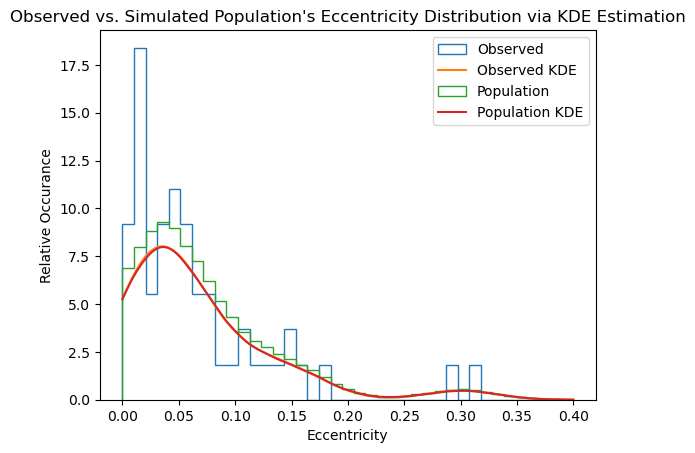

In [5]:
# Initialize the population eccentricites from observered eccentricities: e_list
# Load the data
eccentricity = planet_data['Eccentricity'].to_numpy()

# Remove NaN and infinite values from the array
eccentricity = eccentricity[~np.isnan(eccentricity)]
eccentricity = eccentricity[eccentricity != 0]
eccentricity = eccentricity[np.isfinite(eccentricity)]

# Fit a KDE to the data
kde = gaussian_kde(eccentricity)

# Generate 10000 samples from the KDE
e_list = kde.resample(size=150000)[0]
print(type(e_list))


# Create a histogram of the original data
n, bins, patches = plt.hist(eccentricity, bins=np.linspace(0, 0.4, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
x_grid = np.linspace(0, 0.4, 200)
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(e_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(e_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')
e_list = e_list[e_list > 0]
# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Eccentricity Distribution via KDE Estimation")
plt.xlabel("Eccentricity")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()


<class 'numpy.ndarray'>


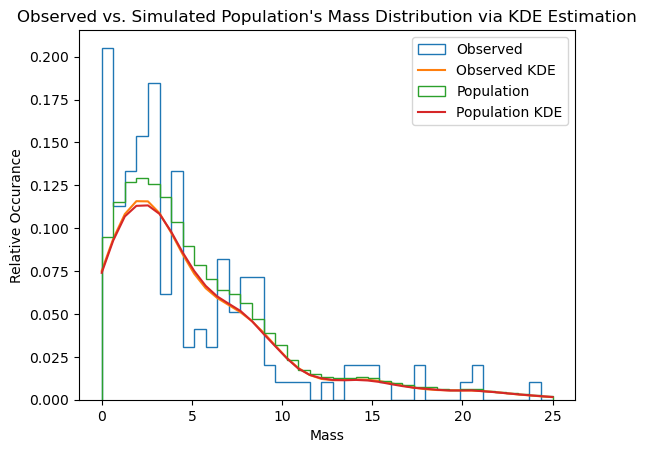

In [6]:
# Initialize the population masses from observered masses: m_list
# Load the data
mass = planet_data['Mass or Mass * sin(i) (M_earth)'].to_numpy()

# Remove NaN and infinite values from the array
mass = mass[~np.isnan(mass)]
mass = mass[mass != 0]
mass = mass[np.isfinite(mass)]
mass = mass[mass < 25]

# Fit a KDE to the data
kde = gaussian_kde(mass)

# Generate 10000 samples from the KDE
m_list = kde.resample(size=150000)[0]
print(type(m_list))


# Create a histogram of the original data
n, bins, patches = plt.hist(mass, bins=np.linspace(0, 25, 40), histtype='step', density=True, label = 'Observed')

# Plot the kernel density curve of the original data
x_grid = np.linspace(0, 25, 40)
plt.plot(x_grid, kde(x_grid), label='Observed KDE')

# Create a histogram of the new samples
n_new, bins_new, patches_new = plt.hist(m_list, bins=bins, histtype='step', density=True, label = 'Population')

# Plot the kernel density curve of the new samples
kde_new = gaussian_kde(m_list)
plt.plot(x_grid, kde_new(x_grid), label='Population KDE')
m_list = m_list[m_list > 0]
# Set plot title, labels, and legend
plt.title("Observed vs. Simulated Population's Mass Distribution via KDE Estimation")
plt.xlabel("Mass")
plt.ylabel("Relative Occurance")
plt.legend()

# Show the plot
plt.show()


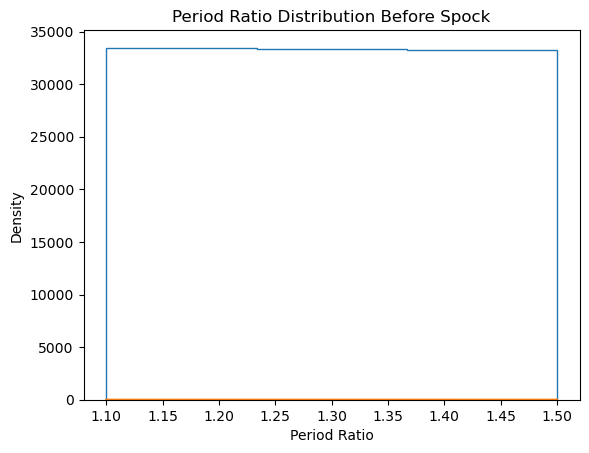

In [7]:
# Initialize uniform period ratio distribution
num_iter = 100000
p_min = 1.1
p_max = 1.5
p_list = []
for i in range(num_iter):
    #Generate p_ratio
    p = np.random.uniform(p_min,p_max)
    p_list.append(p)
    
    
density = stats.gaussian_kde(p_list)
n, x, _ = plt.hist(p_list, bins=np.linspace(1.1,1.5, 4),
                   histtype=u'step', density = False)
plt.plot(x, density(x))
plt.title("Period Ratio Distribution Before Spock")
plt.xlabel("Period Ratio")
plt.ylabel("Density")
plt.show()

In [8]:
#Need p_list (list of period ratios), m_list (list of masses), e_list (list of eccentricities)

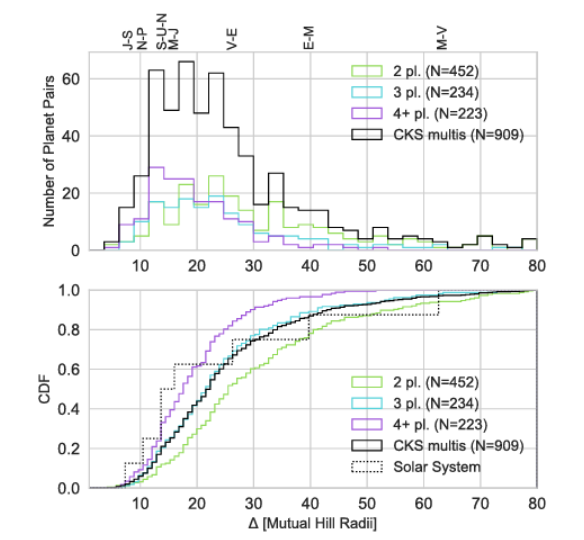

In [9]:
#LOADS OBSERVATIONAL DATA


pairs = pd.read_csv('exoarchive_planet_pairs.csv', index_col=0)
#res2 = np.load('res.npy', allow_pickle=True)

bins=np.linspace(1.1, 1.51, bin_number) 
mask = (pairs['Pratio'] > 1.05) & (pairs['Pratio'] < 1.5)
#count, edges = np.histogram(pairs['Pratio'][mask], bins=bins)
#values = count
#pdf = count/sum(count)
#observed_norm_cumulative = np.cumsum(pdf)
#observed_period_pdf = count
#observed_period_cdf = observed_norm_cumulative
pratios_observed = np.array(pairs['Pratio'][mask])
pratios_observed.sort()
observed_period_cdf = np.cumsum(pratios_observed)/pratios_observed.sum()

def check_crossing(sim):
    ps = sim.particles
    for i1 in range(1,sim.N-1):
        i2 = i1+1 # next planet out 
        EMx = ps[i1].e*np.cos(ps[i1].pomega) - ps[i2].e*np.cos(ps[i2].pomega)
        EMy = ps[i1].e*np.sin(ps[i1].pomega) - ps[i2].e*np.sin(ps[i2].pomega)
        EM = np.sqrt(EMx**2 + EMy**2)
        EMcross = (ps[i2].a-ps[i1].a)/ps[i2].a
        if EM > EMcross:
            return True
    return False


In [10]:
#This only needs to be run once
#This initializes the lists that populations can be added into
list_p_vals = []
list_period_ratios = []

In [11]:
%%time
"""
Run Program - Very important code

Change first "for j in range(x)" value to control how many runs are performed
Change Standard Deviation to control Pearson r

Might not matter based on Prof. tamayo's words: 
Can change sun mass 
Can change base period ratio 

"""
num_experiments = 10
for q in range(num_experiments):
    spock_e_list = []
    spock_p_list = []
    spock_m_list = []
    p_weight_array = []
    triple_weight_array = []
    prob_list = []
    iter_list = []

    pop3_p1list = []
    pop3_p2list = []
    pearson_p_weight_array = []

    hill_radius_diff_list = []

    print("Program Started. Currently on cycle: ")
    for j in range(100):
        # stop once our effective number of samples (i.e. the total probability of all samples) = number of observed pairs
        if np.array(p_weight_array).sum() > len(pratios_observed):
            break
        print(str(j))
        sim_list = []
        for index in range(20):
            #Get eccentricity and mass randomly
            i = int(np.random.uniform(0,10000))
            temp_e1 = e_list[3*i]
            temp_e2 = e_list[3*i+1]
            temp_e3 = e_list[3*i+2]
            temp_m1 = m_list[3*i] 
            temp_m2 = m_list[3*i+1] 
            temp_m3 = m_list[3*i+2] 
            # Get periods based on pearson r requirement and period distribution. 
            #Initialize to base values
            base_period = 1  #PLay with this value based on observed periods, but might not matter
            stdev = 0.15#0.1161#0.1161 #This standard deviation sets the pearson r
            pratio1 = p_list[int(np.random.uniform(0,num_iter))]
            pratio2 = 0
            while (pratio2 < 1.1 or pratio2 > 1.5):
                pratio2 = pratio1 * np.random.normal(1,stdev) #Use random.normal to imitate pearson r - tune stdev to desired pearson r

            #Set the periods based on period ratios and base period
            period_1 = base_period
            period_2 = period_1 * pratio1
            period_3 = period_2 * pratio2

            #Now we make the simulation
            temp_sim = rebound.Simulation()
            temp_sim.add(m=1) #Can possibly change mass of star, but might not matter
            temp_sim.add(m=temp_m1*mass_ratio, P = period_1, e = temp_e1)
            temp_sim.add(m=temp_m2*mass_ratio, P = period_2, e = temp_e2)
            temp_sim.add(m=temp_m3*mass_ratio, P = period_3, e = temp_e3)

            spock_e_list.append(temp_e1)
            spock_e_list.append(temp_e2)
            spock_e_list.append(temp_e3)
            spock_m_list.append(temp_m1)
            spock_m_list.append(temp_m2)
            spock_m_list.append(temp_m3)

            spock_p_list.append(pratio1)
            spock_p_list.append(pratio2)

            sim_list.append(temp_sim)
            pop3_p1list.append(pratio1)
            pop3_p2list.append(pratio2)


            #Hill radius stuff is deprecated
            """
            hill_radius_1 = a1 * ( (temp_m1 + temp_m2)*earth_mass / (3*sun_mass))**(1/3) #Deprecated
            hill_radius_2 = a2 * ( (temp_m2 + temp_m3)*earth_mass / (3*sun_mass))**(1/3) #Deprecated
            max_p2 = 1.5 * temp_p1
            max_a2 = max_p2**(2/3)
            max_hill_diff = max_a2 - a1
            #print("max hill difference: ", max_hill_diff/hill_radius_1)
            hill_radius_diff_1 = (a2-a1)/hill_radius_1
            hill_radius_diff_2 = (a3-a2)/hill_radius_2
            hill_radius_diff_list.append(hill_radius_diff_1)
            hill_radius_diff_list.append(hill_radius_diff_2)
            """

        temp_p_weight_array = fmodel.predict_stable(sim_list)
        for csim_index in range(len(sim_list)):
            if check_crossing(sim_list[csim_index]):
                temp_p_weight_array[csim_index] = 0

        temp_pearson_p_weight_array = temp_p_weight_array
        pearson_p_weight_array = np.concatenate([pearson_p_weight_array, temp_pearson_p_weight_array])

        temp_triple_weight_array = np.repeat(temp_p_weight_array, 3)
        temp_p_weight_array = np.repeat(temp_p_weight_array, 2)
        p_weight_array = np.concatenate([p_weight_array, temp_p_weight_array])
        triple_weight_array = np.concatenate([triple_weight_array, temp_triple_weight_array])



        spock_p_values, spock_p_base = np.histogram(spock_p_list , weights = p_weight_array, bins=np.linspace(1.1, 1.51, bin_number))
        spock_p_cumsum = np.cumsum(spock_p_values)/max(np.cumsum(spock_p_values))

        #Manual Weighting
        estimator = sns.distributions.ECDF('proportion', complementary=False)
        stat, p_vals = estimator(spock_p_list, weights=p_weight_array)
        p_vals[0] = 1 # otherwise gets set to -np.inf
        period_ratios = stat

        #Here we calculate the p value and add it to our prob_list

        ksprob = scipy.stats.kstest(period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                    method = 'exact')    
        pvalue = ksprob[1]
        prob_list.append(pvalue)
        iter_list.append(len(spock_p_list))

    list_p_vals.append(p_vals)
    list_period_ratios.append(period_ratios)

Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
Program Started. Currently on cycle: 
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31

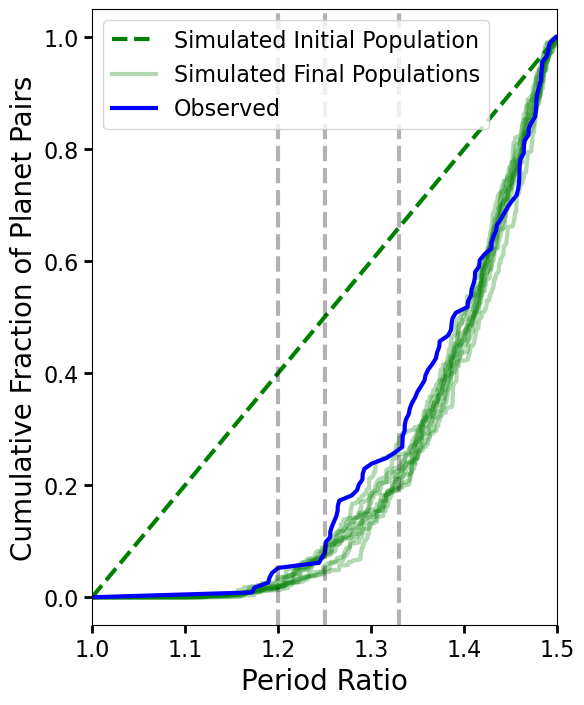

In [23]:
#Below we generate the plots for our population
plt.style.use('./paper.mplstyle')
fig, ax = plt.subplots(figsize=(6,8))

ax.plot([1,1.5], [0,1], 'g--', label='Simulated Initial Population')
for q in range(num_experiments):
    p_vals = list_p_vals[q]
    period_ratios = list_period_ratios[q]
    if q == 0:
        ax.plot(p_vals, period_ratios, c = 'green', alpha = 0.3, label='Simulated Final Populations')
    else:
        ax.plot(p_vals, period_ratios, c = 'green', alpha = 0.3)
ax.plot([1] + list(pratios_observed), [0]+list(observed_period_cdf), c = 'blue', label='Observed')
ax.axvline(1.2, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.25, color='black', linestyle='--', alpha=0.3)
ax.axvline(1.33, color='black', linestyle='--', alpha=0.3)
ax.legend()
ax.set_xlabel("Period Ratio")
ax.set_ylabel("Cumulative Fraction of Planet Pairs")
ax.set_xlim([1.,1.5])
fig.savefig('inneredge.pdf', bbox_inches='tight')

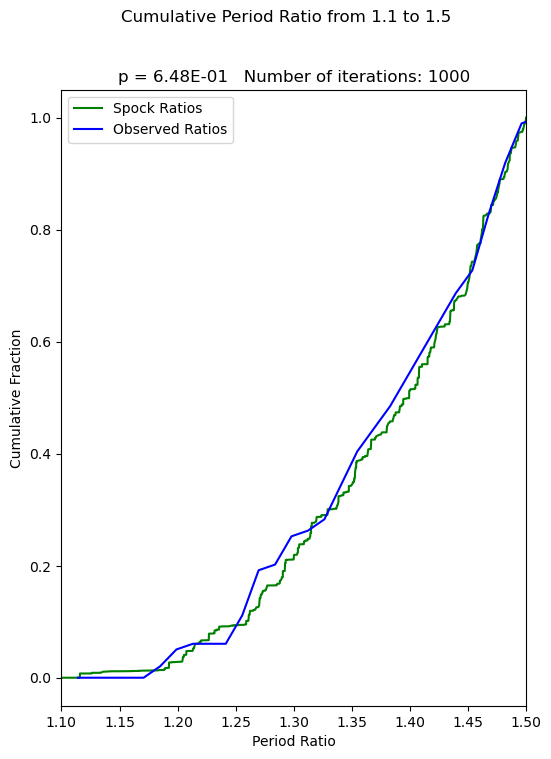

<Figure size 1000x100 with 0 Axes>

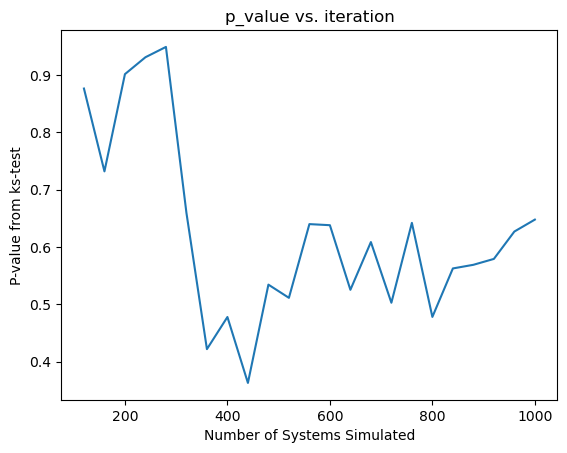

In [27]:
#Below we generate the plots for our population

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(6)



plt.plot(p_vals, period_ratios, c = 'green')
plt.plot(edges[1:], observed_period_cdf, c = 'blue')
plt.legend(["Spock Ratios", "Observed Ratios"])
plt.suptitle("Cumulative Period Ratio from 1.1 to 1.5")
plt.title("p = " + '%.2E' % Decimal( str(prob_list[-1])  ) + "   Number of iterations: " + str(len(spock_p_list)))
plt.xlabel("Period Ratio")
plt.ylabel("Cumulative Fraction")
plt.xlim(1.1,1.5)
plt.figure(figsize=(10, 1))
plt.show()


plt.plot(iter_list,prob_list)
plt.title("p_value vs. iteration")
plt.xlabel("Number of Systems Simulated")
plt.ylabel("P-value from ks-test")
plt.show()


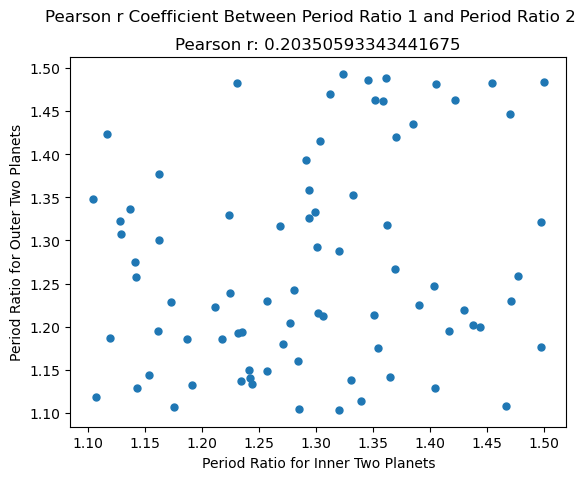

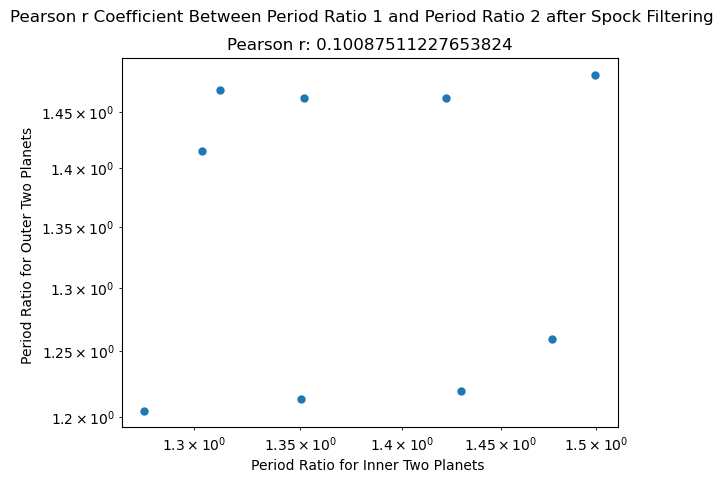

In [14]:
#Here I calculate the Pearson r of the resulting population


#pop3_p1list = np.log(pop3_p1list)
#pop3_p2list = np.log(pop3_p2list)

my_rho = np.corrcoef(pop3_p1list, pop3_p2list)
pearson_r = my_rho[0][1]
#plt.style.use('seaborn-whitegrid')
plt.plot(pop3_p1list, pop3_p2list, 'o', markersize = 5)
plt.xlabel("Period Ratio for Inner Two Planets")
plt.ylabel("Period Ratio for Outer Two Planets")
plt.title("Pearson r: " + str(pearson_r))
plt.suptitle('Pearson r Coefficient Between Period Ratio 1 and Period Ratio 2')
plt.show()



pearson_pop3_p1_list = []
pearson_pop3_p2_list = []

pearson_cutoff_prob = 0.1    #



for index in range(len(pearson_p_weight_array)):
    if pearson_p_weight_array[index] > pearson_cutoff_prob:
        pearson_pop3_p1_list.append(pop3_p1list[index])
        pearson_pop3_p2_list.append(pop3_p2list[index])


my_rho = np.corrcoef(pearson_pop3_p1_list, pearson_pop3_p2_list)

pearson_r = my_rho[0][1]

#plt.style.use('seaborn-whitegrid')

plt.plot(pearson_pop3_p1_list, pearson_pop3_p2_list, 'o', markersize = 5)


plt.xlabel("Period Ratio for Inner Two Planets ")
plt.ylabel("Period Ratio for Outer Two Planets ")
plt.xscale('log')
plt.yscale('log')
plt.title("Pearson r: " + str(pearson_r))
plt.suptitle('Pearson r Coefficient Between Period Ratio 1 and Period Ratio 2 after Spock Filtering')
plt.show()


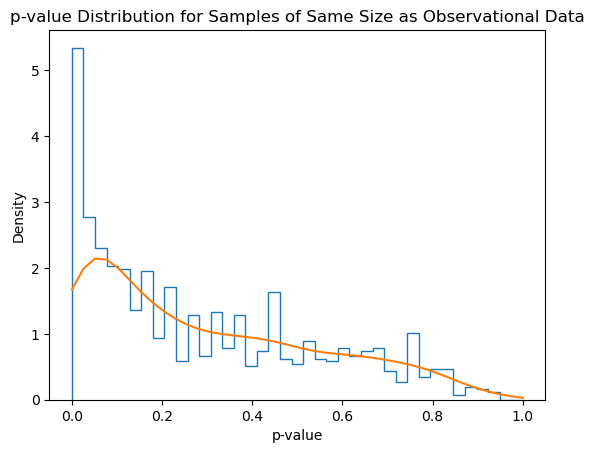

In [15]:
#Here we get a distribution of p-values by choosing many different outcomes. 
#Assume the length of period ratio list is 10,000
#We are going to make Sampled Populations of size 100, calculate p-values, and then make a distribution. 

sample_p_value_list = []



estimator = sns.distributions.ECDF('proportion', complementary=False)
for i in range(1000):
    sample_pratio_list = []
    sample_pratio_weights_list = []
    for j in range(100):
        rand_indx = int(np.random.uniform(0,len(spock_p_list)))
        sample_pratio_list.append(spock_p_list[rand_indx])
        sample_pratio_weights_list.append(p_weight_array[rand_indx])
    #Now that we have a sample_pratio_list, calculate a p_value and append it to the sample_p_value_list
    stat, sample_p_vals = estimator(sample_pratio_list, weights=sample_pratio_weights_list)
    sample_period_ratios = stat
    #Here we calculate the p value and add it to our sample_p_value_list
    ksprob = scipy.stats.kstest(sample_period_ratios, observed_period_cdf, args = (), alternative = 'two-sided',
                                method = 'exact')    
    pvalue = ksprob[1]
    sample_p_value_list.append(pvalue)


density = stats.gaussian_kde(sample_p_value_list)
n, x, _ = plt.hist(sample_p_value_list, bins=np.linspace(0, 1, 40),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("p-value Distribution for Samples of Same Size as Observational Data")
plt.xlabel("p-value")
plt.ylabel("Density")
plt.show()

/mnt/ssd/home/bbonifacio/anaconda3/envs/bbonifacio/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


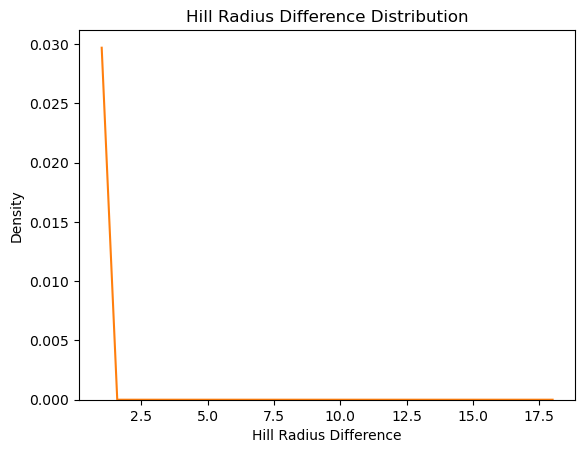

In [16]:
#hill_radius_diff_list

n, x, _ = plt.hist(hill_radius_diff_list, bins=np.linspace(1,18, 30),
                   histtype=u'step', density = True)
plt.plot(x, density(x))
plt.title("Hill Radius Difference Distribution")
plt.xlabel("Hill Radius Difference")
plt.ylabel("Density")
plt.show()


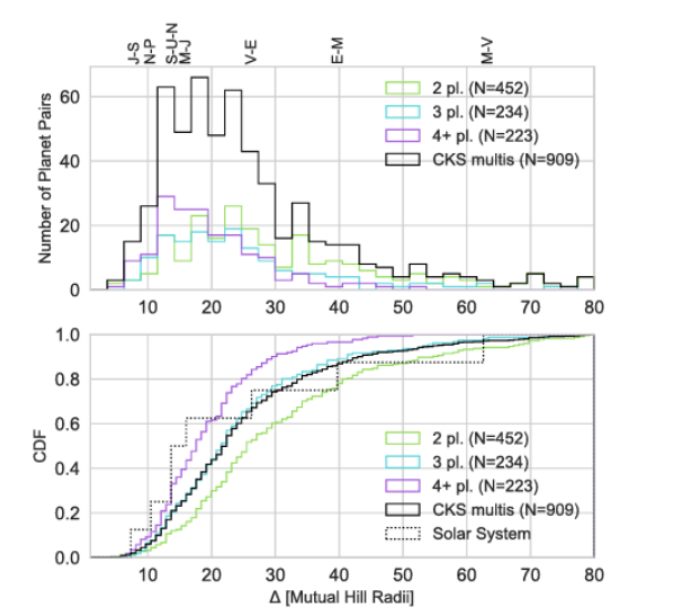

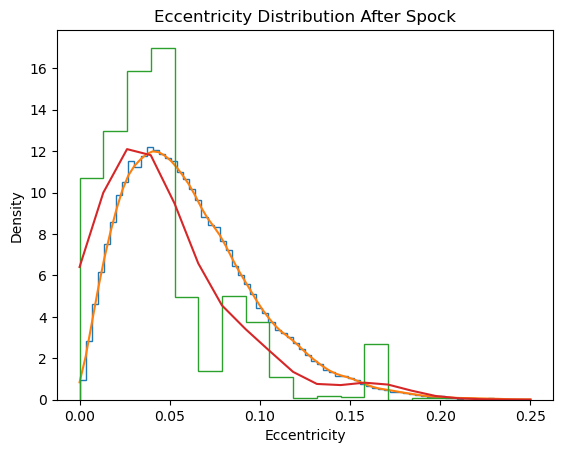

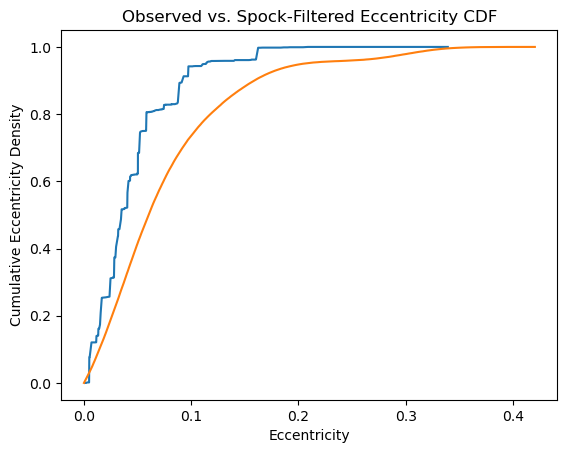

In [17]:
plt.figure()

num_iter =100000
obs_e_mean = 0.049      #0.02632     #settings["planetary_system"]["mean_e"]
obs_e_error=  0.013     #settings["planetary_system"]["e_error"]

obs_e_list = []
    
while len(obs_e_list) < num_iter:
    #Generate e from Rayleigh Distribution
    scale = np.random.normal(obs_e_mean, obs_e_error)
    if scale < 0:
        scale = 0
    e = np.random.rayleigh(scale = scale)
    if not (e < 0 or e > 1):
        obs_e_list.append(e)


density = stats.gaussian_kde(obs_e_list)
n, x, _ = plt.hist(obs_e_list, bins=np.linspace(0, 0.25, 75),
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution Before Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")




density = stats.gaussian_kde(spock_e_list, weights = triple_weight_array)
n, x, _ = plt.hist(spock_e_list, bins=np.linspace(0, 0.25, 20), weights = triple_weight_array,
                   histtype=u'step', density=True)  
plt.plot(x, density(x))

plt.title("Eccentricity Distribution After Spock")
plt.xlabel("Eccentricity")
plt.ylabel("Density")
plt.show()



#Above plots the pdf's of the e_lists. 
#Below gets the cdf's and p-value





#Calculate that p-value
stat, sample_e_vals = estimator(spock_e_list, weights=triple_weight_array)
sample_e_ratios = stat

plt.plot(sample_e_vals, stat)

stat, obs_sample_e_vals = estimator(e_list)
obs_e_ratios = stat


plt.xlabel("Eccentricity")
plt.ylabel("Cumulative Eccentricity Density")
plt.title("Observed vs. Spock-Filtered Eccentricity CDF")
plt.plot(obs_sample_e_vals, stat)
plt.show()

#Here we calculate the p value and add it to our sample_p_value_list
#ksprob = scipy.stats.kstest(sample_e_ratios, obs_e_ratios, args = (), alternative = 'two-sided',
#                            method = 'exact')    
#pvalue = ksprob[1]

#print("P-value: " + str(pvalue))



In [8]:
#import dill
#dill.dump_session('pop_1_env.db')